## Introduction
In this notebook, I will apply CRISP-DM steps on [Seattle-Airbnb-data](https://www.kaggle.com/datasets/airbnb/seattle) to answer below questions:
1. Which are the top five highly rated hosts? Are all of them superhosts? 
2. Are the top ten reviewing/loyal customers satisfied or in simple words have they rated on higher side or lower side than average rating?
3. What are the most correlated features with price of the listing? 
4. Does review rating and cancellation policy have any influence on price? If yes how much compared to other features?

### Data Description
There are three datasets provided in Seattle-Airbnb-data.The following Airbnb activity is included in this Seattle dataset:

1. Listings, including full descriptions and average review score
2. Reviews, including unique id for each reviewer and detailed comments
3. Calendar, including listing id and the price and availability for that day
<br> Lets take a peek at each dataset.

In [19]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import shap

import warnings
warnings.filterwarnings('ignore')


In [20]:
#Load data
reviews = pd.read_csv(r"Data\DSND\reviews.csv")
listing = pd.read_csv("Data\DSND\listings.csv")
cal = pd.read_csv("Data/DSND/calendar.csv")

In [21]:
from IPython.display import display, HTML
print("Reviews")
display(HTML(reviews.head(5).to_html()))
print("listing")
display(listing.head(5))
print("calendar")
display(cal.head(5))

Reviews


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to everything!
1,7202016,39087409,2015-07-20,32440555,Frank,"Kelly has a great room in a very central location. \r\nBeautiful building , architecture and a style that we really like. \r\nWe felt guite at home here and wish we had spent more time.\r\nWent for a walk and found Seattle Center with a major food festival in progress. What a treat.\r\nVisited the Space Needle and the Chihuly Glass exhibit. Then Pikes Place Market. WOW. Thanks for a great stay."
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighborhood. This is the kind of apartment I wish I had!\r\n\r\nDidn't really get to meet Kelly until I was on my out, but she was always readily available by phone. \r\n\r\nI believe the only ""issue"" (if you want to call it that) was finding a place to park, but I sincerely doubt its easy to park anywhere in a residential area after 5 pm on a Friday"
3,7202016,40813543,2015-08-02,33671805,George,"Close to Seattle Center and all it has to offer - ballet, theater, museum, Space Needle, restaurants of all ilk just blocks away, and the Metropolitan (probably the coolest grocer you'll ever find). Easy to find and Kelly was warm, welcoming, and really interesting to talk to."
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating in a great neighborhood. She has some great coffee and while I wasn't around much during my stay the time I spent interacting with her was very pleasant. \r\n\r\nThe apartment is in a great location and very close to the Seattle Center. The neighborhood itself has a lot of good food as well!


listing


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


calendar


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


## Data Preparation and Cleaning
The dataset 'calendar' has information about the availability and price of the listings on a given day. Since we are not conerned about the time aspect of the listings we will exclude this dataset as clearly both availability and price of a given listing is also present in the 'listing' dataset.
<br>Also since we want the features that are relevant to listing price we will exclude features like image_url,listing_url etc.

In [22]:
display(listing.columns.values)


array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       

In [23]:
# Following columns are relevant to questions at hand from listing dataset
relevant_cols = ['id','host_id','host_response_time', 'host_response_rate',
'host_acceptance_rate', 'host_is_superhost', 'host_total_listings_count','host_identity_verified',
'neighbourhood', 'property_type', 'room_type','accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
'square_feet', 'price', 'security_deposit', 'cleaning_fee','has_availability',
'number_of_reviews', 'review_scores_rating', 'cancellation_policy'
]
listing_filtered = listing[relevant_cols]

In [24]:
listing_filtered.head(3)

,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,property_type,...,beds,bed_type,square_feet,price,security_deposit,cleaning_fee,has_availability,number_of_reviews,review_scores_rating,cancellation_policy
0,241032,956883,within a few hours,96%,100%,f,3.0,t,Queen Anne,Apartment,...,1.0,Real Bed,NaN,$85.00,NaN,NaN,t,207,95.0,moderate
1,953595,5177328,within an hour,98%,100%,t,6.0,t,Queen Anne,Apartment,...,1.0,Real Bed,NaN,$150.00,$100.00,$40.00,t,43,96.0,strict
2,3308979,16708587,within a few hours,67%,100%,f,2.0,t,Queen Anne,House,...,7.0,Real Bed,NaN,$975.00,"$1,000.00",$300.00,t,20,97.0,strict


In [25]:
# As seen some of the columns need cleaning like convert '96%' --> '96' , '$85' --> '85', etc.

listing_filtered['host_response_rate'] = listing_filtered['host_response_rate'].apply(lambda x: float(str(x).replace('%','')))
listing_filtered['host_acceptance_rate'] = listing_filtered['host_acceptance_rate'].apply(lambda x: float(str(x).replace('%','')))
listing_filtered['price'] = listing_filtered['price'].apply(lambda x: float(str(x).replace('$','').replace(',','')))
listing_filtered['security_deposit'] = listing_filtered['security_deposit'].apply(lambda x: float(str(x).replace('$','').replace(',','')))
listing_filtered['cleaning_fee'] = listing_filtered['cleaning_fee'].apply(lambda x: float(str(x).replace('$','').replace(',','')))





In [26]:
listing_filtered.head(3)

,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,property_type,...,beds,bed_type,square_feet,price,security_deposit,cleaning_fee,has_availability,number_of_reviews,review_scores_rating,cancellation_policy
0,241032,956883,within a few hours,96.0,100.0,f,3.0,t,Queen Anne,Apartment,...,1.0,Real Bed,NaN,85.0,NaN,NaN,t,207,95.0,moderate
1,953595,5177328,within an hour,98.0,100.0,t,6.0,t,Queen Anne,Apartment,...,1.0,Real Bed,NaN,150.0,100.0,40.0,t,43,96.0,strict
2,3308979,16708587,within a few hours,67.0,100.0,f,2.0,t,Queen Anne,House,...,7.0,Real Bed,NaN,975.0,1000.0,300.0,t,20,97.0,strict


In [27]:
#checking which of the columns are categorical and which are numerical columns
listing_filtered.dtypes

id                             int64
host_id                        int64
host_response_time            object
host_response_rate           float64
host_acceptance_rate         float64
host_is_superhost             object
host_total_listings_count    float64
host_identity_verified        object
neighbourhood                 object
property_type                 object
room_type                     object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
bed_type                      object
square_feet                  float64
price                        float64
security_deposit             float64
cleaning_fee                 float64
has_availability              object
number_of_reviews              int64
review_scores_rating         float64
cancellation_policy           object
dtype: object

## Question 1
What are the top five highly rated hosts? Are all of them superhosts?
<br> As seen from the data the criteria of highly rated hosts should involve both number of reviews as well as the rating. If we see closely we see rating is missing for those records where number of reviews is zero. We may need to take care of the missing values first.

In [28]:
def fill_rating(x):
    '''
    Setting value of review_score_rating to zero
    for every zero number of reviews.
    
    '''
    if x['number_of_reviews'] == 0:
        x['review_scores_rating']=0
    return x
listing_filtered = listing_filtered.apply(lambda x : fill_rating(x), axis=1)

In [29]:
listing_filtered.isna().sum()

id                              0
host_id                         0
host_response_time            523
host_response_rate            523
host_acceptance_rate          773
host_is_superhost               2
host_total_listings_count       2
host_identity_verified          2
neighbourhood                 416
property_type                   1
room_type                       0
accommodates                    0
bathrooms                      16
bedrooms                        6
beds                            1
bed_type                        0
square_feet                  3721
price                           0
security_deposit             1952
cleaning_fee                 1030
has_availability                0
number_of_reviews               0
review_scores_rating           20
cancellation_policy             0
dtype: int64

In [30]:
#As seen from above we still have 20 missing values in ratings lets find out those
lf = listing_filtered.copy(deep=True)
lf['review_scores_rating'] = lf['review_scores_rating'].fillna('Missing')

In [31]:
lf[lf['review_scores_rating']=='Missing']

,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,property_type,...,beds,bed_type,square_feet,price,security_deposit,cleaning_fee,has_availability,number_of_reviews,review_scores_rating,cancellation_policy
204,9028447,2704826,within a few hours,80.0,100.0,f,1.0,f,NaN,Apartment,...,1.0,Real Bed,NaN,100.0,NaN,NaN,t,1,Missing,moderate
283,5336585,27656377,NaN,NaN,NaN,f,1.0,t,Wallingford,Loft,...,1.0,Real Bed,NaN,75.0,NaN,NaN,t,1,Missing,flexible
361,8207848,31148752,within a few hours,99.0,100.0,f,354.0,t,Fremont,Apartment,...,2.0,Real Bed,NaN,259.0,NaN,155.0,t,1,Missing,strict
482,186328,895223,NaN,NaN,NaN,f,1.0,t,Queen Anne,House,...,2.0,Real Bed,NaN,250.0,100.0,100.0,t,1,Missing,strict
527,790860,4186082,NaN,NaN,NaN,f,1.0,f,Green Lake,Apartment,...,1.0,Real Bed,NaN,450.0,500.0,250.0,t,1,Missing,moderate
774,7536074,39485528,within an hour,100.0,100.0,f,1.0,t,University District,Apartment,...,2.0,Real Bed,NaN,185.0,NaN,NaN,t,1,Missing,flexible
804,7807658,41099211,within a day,100.0,NaN,f,1.0,t,University District,Apartment,...,2.0,Real Bed,NaN,118.0,NaN,NaN,t,1,Missing,flexible
1024,8103432,2405911,within a day,75.0,100.0,f,1.0,t,Atlantic,House,...,2.0,Real Bed,NaN,140.0,NaN,50.0,t,1,Missing,strict
1457,9012948,3954802,within a day,100.0,100.0,f,1.0,t,NaN,Apartment,...,1.0,Real Bed,NaN,130.0,NaN,NaN,t,1,Missing,flexible
1702,8338155,41925688,within an hour,100.0,100.0,f,1.0,t,First Hill,Apartment,...,1.0,Real Bed,NaN,65.0,NaN,35.0,t,1,Missing,moderate


In [32]:
#Clearly from above we see Missing values in ratings whereever we have exactly one review, 
# for the sake of getting top five highly rated hosts lets fill Missing rating with average rating of all the listings.
# Fill numeric column with the mean
col = ['review_scores_rating']
listing_filtered[col] = listing_filtered[col].fillna((listing_filtered[col].mean()))
listing_filtered.isna().sum()


id                              0
host_id                         0
host_response_time            523
host_response_rate            523
host_acceptance_rate          773
host_is_superhost               2
host_total_listings_count       2
host_identity_verified          2
neighbourhood                 416
property_type                   1
room_type                       0
accommodates                    0
bathrooms                      16
bedrooms                        6
beds                            1
bed_type                        0
square_feet                  3721
price                           0
security_deposit             1952
cleaning_fee                 1030
has_availability                0
number_of_reviews               0
review_scores_rating            0
cancellation_policy             0
dtype: int64

Now lets find out top five highly rated hosts based on weighted_rating_score = number_of_reviews*review_scores_rating

In [33]:
listing_filtered['weighted_rating_score'] = listing_filtered['number_of_reviews']*listing_filtered['review_scores_rating']

In [34]:
top_five_hosts = listing_filtered.sort_values('weighted_rating_score',ascending=False)[:6]
top_five_hosts

,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,property_type,...,bed_type,square_feet,price,security_deposit,cleaning_fee,has_availability,number_of_reviews,review_scores_rating,cancellation_policy,weighted_rating_score
1447,208356,1025723,within an hour,100.0,100.0,f,3.0,t,International District,Loft,...,Real Bed,NaN,89.0,250.0,NaN,t,474,95.0,strict,45030.0
1441,365550,1025723,within an hour,100.0,100.0,f,3.0,t,International District,Loft,...,Real Bed,NaN,89.0,250.0,NaN,t,466,94.0,strict,43804.0
3083,25002,102684,within a few hours,94.0,100.0,t,1.0,f,Ballard,House,...,Real Bed,NaN,75.0,NaN,15.0,t,404,98.0,flexible,39592.0
3600,47196,212740,within an hour,90.0,100.0,f,1.0,f,Stevens,House,...,Real Bed,NaN,65.0,NaN,15.0,t,353,93.0,moderate,32829.0
2568,63308,308927,within a few hours,100.0,100.0,t,2.0,t,Montlake,House,...,Real Bed,NaN,89.0,NaN,NaN,t,320,98.0,moderate,31360.0
1499,92835,391714,within an hour,100.0,100.0,f,2.0,t,Central Business District,Apartment,...,Real Bed,NaN,99.0,NaN,30.0,t,319,94.0,strict,29986.0


If we see above we have duplicate host_ids in top host list we can consider next best host 

In [35]:
top_five_hosts = top_five_hosts.drop_duplicates(subset=['host_id'])
top_five_hosts['host_id'] = top_five_hosts['host_id'].astype(str)

fig = px.bar(top_five_hosts, x="host_id", y="weighted_rating_score", color="host_is_superhost", title="Top Five Hosts as per weighted rating score and whether a superhost or not")
fig.layout.xaxis.type="category"
fig.show()

Clearly not all of the top five hosts are categorized as super host infact in top five three are categorized as not a super host.

## Question 2
Are the top ten reviewing/loyal customers satisfied or in simple words have they rated on higher side or lower side than average rating?
<br>Lets try to answer this.


In [36]:
#First Calculate average rating
average_rating_overall = listing_filtered['review_scores_rating'].mean()
print(average_rating_overall)

78.93206951026856


In [37]:
# First find top ten loyal customers from reviews dataset
top_ten_reviewers = reviews['reviewer_id'].value_counts().to_frame().sort_values(['reviewer_id'],ascending=False).reset_index().rename(columns = {'index':'reviewer_id','reviewer_id':'count'})[:10]
top_ten_reviewers

,reviewer_id,count
0,206203,67
1,15121499,32
2,5775807,19
3,2734499,19
4,29590276,18
5,7448809,17
6,8013961,16
7,1971733,14
8,41158892,14
9,5053141,14


In [38]:
list_of_top_rev = top_ten_reviewers['reviewer_id'].values
top_reviewer = reviews[reviews['reviewer_id'].isin(list_of_top_rev)]
top_reviewer

,listing_id,id,date,reviewer_id,reviewer_name,comments
292,7550234,49947935,2015-10-07,41158892,Paige,"While I didn't get to meet Dario or Ethan, I h..."
838,1707064,8014797,2013-10-12,2734499,Jason,Super awesome landing pad for centrally locate...
939,1707064,29648122,2015-04-10,15121499,Kathryn,This place is AWESOME!!!! It has so much chara...
2614,23356,28828602,2015-03-30,2734499,Jason,Great location. Safe neighborhood. Definitely ...
2921,4279876,29077094,2015-04-03,15121499,Kathryn,Beth was a great host! Super communicative and...
...,...,...,...,...,...,...
82500,9568491,55514551,2015-12-01,41158892,Paige,"Erika was an awesome, super friendly host! I h..."
83527,3916050,46663280,2015-09-12,41158892,Paige,"Lisa's was kind and friendly, even though we r..."
83691,6707735,46677840,2015-09-12,15121499,Kathryn,This place is so charming! Everything that you...
83991,442487,1536904,2012-06-22,206203,Amanda,The lovely garden studio is indeed lovely with...


In [39]:
listing_filtered.rename(columns={'id':'listing_id'},inplace=True)

In [40]:
merged_rev = pd.merge(top_reviewer,listing_filtered,on=['listing_id'],how='left')[['listing_id','reviewer_id','review_scores_rating']]
merged_rev

,listing_id,reviewer_id,review_scores_rating
0,7550234,41158892,94.0
1,1707064,2734499,96.0
2,1707064,15121499,96.0
3,23356,2734499,83.0
4,4279876,15121499,97.0
...,...,...,...
225,9568491,41158892,100.0
226,3916050,41158892,86.0
227,6707735,15121499,97.0
228,442487,206203,94.0


In [41]:
top_ten_rev_rating = merged_rev.groupby(['reviewer_id']).agg({'review_scores_rating':'mean'}).reset_index()
top_ten_rev_rating

,reviewer_id,review_scores_rating
0,206203,95.970149
1,1971733,96.142857
2,2734499,92.947368
3,5053141,97.214286
4,5775807,95.894737
5,7448809,94.294118
6,8013961,94.562500
7,15121499,96.906250
8,29590276,96.611111
9,41158892,95.000000


Clearly all the top ten reviewers have average rating well above the overall average rating of listings in Seattle, that implies loyal customers are pretty satisfied customers.

### Question 3
What are the most correlated features with price of the listing?
<br> Lets answer this one too.

In [42]:
#But first drop useless columns like square_feet which is > 97% missing
listing_filtered.describe()

,listing_id,host_id,host_response_rate,host_acceptance_rate,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,square_feet,price,security_deposit,cleaning_fee,number_of_reviews,review_scores_rating,weighted_rating_score
count,3.818000e+03,3.818000e+03,3295.000000,3045.000000,3816.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,1866.000000,2788.000000,3818.000000,3818.000000,3818.000000
mean,5.550111e+06,1.578556e+07,94.886798,99.967159,7.157757,3.349398,1.259469,1.307712,1.735394,854.618557,127.976166,287.610397,61.710904,22.223415,78.932070,2108.837779
std,2.962660e+06,1.458382e+07,11.866705,1.812201,28.628149,1.977599,0.590369,0.883395,1.139480,671.404893,90.250022,270.222690,48.830341,37.730892,35.524907,3590.384744
min,3.335000e+03,4.193000e+03,17.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,20.000000,95.000000,5.000000,0.000000,0.000000,0.000000
25%,3.258256e+06,3.275204e+06,98.000000,100.000000,1.000000,2.000000,1.000000,1.000000,1.000000,420.000000,75.000000,150.000000,25.000000,2.000000,87.000000,160.000000
50%,6.118244e+06,1.055814e+07,100.000000,100.000000,1.000000,3.000000,1.000000,1.000000,1.000000,750.000000,100.000000,250.000000,50.000000,9.000000,95.000000,819.000000
75%,8.035127e+06,2.590309e+07,100.000000,100.000000,3.000000,4.000000,1.000000,2.000000,2.000000,1200.000000,150.000000,300.000000,83.000000,26.000000,98.000000,2475.000000
max,1.034016e+07,5.320861e+07,100.000000,100.000000,502.000000,16.000000,8.000000,7.000000,15.000000,3000.000000,1000.000000,5000.000000,300.000000,474.000000,100.000000,45030.000000


In [43]:
listing_filtered = listing_filtered.drop('square_feet',axis=1)

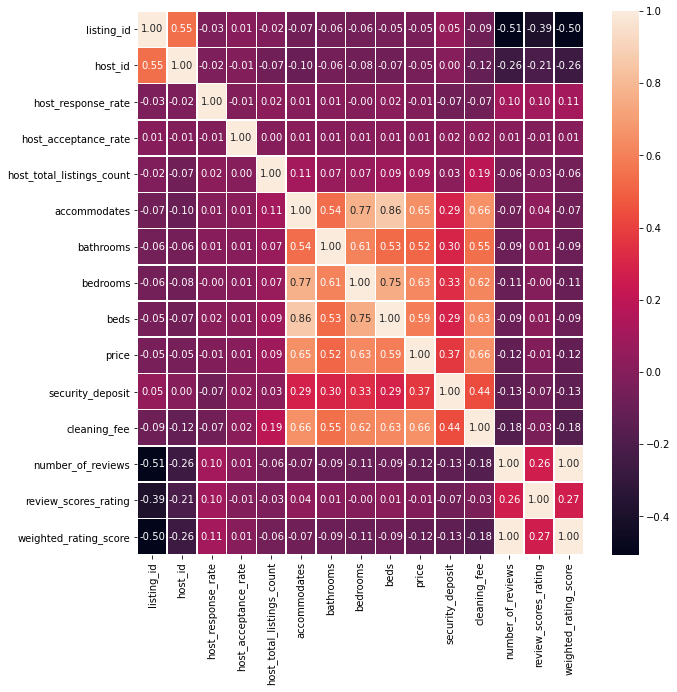

In [44]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(listing_filtered.corr(),annot=True, linewidths=.5, ax=ax,fmt='.2f');

As seen from above most correlated features with Price of listing are:
['accommodates', 'bathrooms', 'bedrooms','beds', 'security_deposit', 'cleaning_fee']

### Question 4
Does review rating and cancellation policy have any influence on price? If yes how much compared to other features?
<br>As seen from the correlation plot we see there is hardly any relation but correlation doesn't explain causality so to answer this we will have to quantify predictive power of both review rating and cancellation policy towards price prediction.
<br> That means we will need to build a predictive model and based on shap values of features we will calculate/quantify the predictive power of each feature (both categorical and numerical).

In [45]:
listing_filtered = listing_filtered.drop(['listing_id','host_id'],axis=1)

In [46]:
listing_filtered.isna().sum()

host_response_time            523
host_response_rate            523
host_acceptance_rate          773
host_is_superhost               2
host_total_listings_count       2
host_identity_verified          2
neighbourhood                 416
property_type                   1
room_type                       0
accommodates                    0
bathrooms                      16
bedrooms                        6
beds                            1
bed_type                        0
price                           0
security_deposit             1952
cleaning_fee                 1030
has_availability                0
number_of_reviews               0
review_scores_rating            0
cancellation_policy             0
weighted_rating_score           0
dtype: int64

In [47]:
val = listing_filtered['neighbourhood'].mode().item()
print(val)

Capitol Hill


In [49]:
le = preprocessing.LabelEncoder()
listing_filtered['neighbourhood'] = listing_filtered['neighbourhood'].fillna(val)
listing_filtered['neighbourhood'] = le.fit_transform(listing_filtered['neighbourhood'])


In [50]:
listing_filtered

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,property_type,room_type,accommodates,...,beds,bed_type,price,security_deposit,cleaning_fee,has_availability,number_of_reviews,review_scores_rating,cancellation_policy,weighted_rating_score
0,within a few hours,96.0,100.0,f,3.0,t,59,Apartment,Entire home/apt,4,...,1.0,Real Bed,85.0,NaN,NaN,t,207,95.0,moderate,19665.0
1,within an hour,98.0,100.0,t,6.0,t,59,Apartment,Entire home/apt,4,...,1.0,Real Bed,150.0,100.0,40.0,t,43,96.0,strict,4128.0
2,within a few hours,67.0,100.0,f,2.0,t,59,House,Entire home/apt,11,...,7.0,Real Bed,975.0,1000.0,300.0,t,20,97.0,strict,1940.0
3,NaN,NaN,NaN,f,1.0,t,59,Apartment,Entire home/apt,3,...,2.0,Real Bed,100.0,NaN,NaN,t,0,0.0,flexible,0.0
4,within an hour,100.0,NaN,f,2.0,t,59,House,Entire home/apt,6,...,3.0,Real Bed,450.0,700.0,125.0,t,38,92.0,strict,3496.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,within a few hours,99.0,100.0,f,354.0,t,20,House,Entire home/apt,6,...,3.0,Real Bed,359.0,NaN,230.0,t,1,80.0,strict,80.0
3814,within an hour,100.0,100.0,f,1.0,t,58,Apartment,Entire home/apt,4,...,2.0,Real Bed,79.0,500.0,50.0,t,2,100.0,moderate,200.0
3815,NaN,NaN,NaN,f,1.0,f,10,House,Entire home/apt,2,...,1.0,Real Bed,93.0,250.0,35.0,t,0,0.0,moderate,0.0
3816,within an hour,100.0,NaN,f,1.0,t,10,Condominium,Entire home/apt,2,...,1.0,Real Bed,99.0,300.0,45.0,t,0,0.0,moderate,0.0


In [51]:
# First lets impute missing values for both categorical and numerical features

llf = listing_filtered.copy(deep=True)
num_vars = llf.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
    llf[col].fillna((llf[col].mean()), inplace=True)

# Dummy the categorical variables
cat_vars = llf.select_dtypes(include=['object']).copy().columns.tolist()
for cols in cat_vars:
    llf[cols].fillna((llf[cols].mode()),inplace=True)
for var in  cat_vars:
    # for each cat add dummy var, drop original column
    llf = pd.concat([llf.drop(var, axis=1), pd.get_dummies(llf[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)


In [52]:
llf.isna().sum()

host_response_rate                       0
host_acceptance_rate                     0
host_total_listings_count                0
neighbourhood                            0
accommodates                             0
bathrooms                                0
bedrooms                                 0
beds                                     0
price                                    0
security_deposit                         0
cleaning_fee                             0
number_of_reviews                        0
review_scores_rating                     0
weighted_rating_score                    0
host_response_time_within a day          0
host_response_time_within a few hours    0
host_response_time_within an hour        0
host_is_superhost_t                      0
host_identity_verified_t                 0
property_type_Bed & Breakfast            0
property_type_Boat                       0
property_type_Bungalow                   0
property_type_Cabin                      0
property_ty

In [54]:
#Preparing data for machine learning model prediction
X = llf.drop('price',axis=1)
y = llf['price']

In [55]:
#splitting dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [56]:
#Instantiating a XGBoost model and predicting on test datset
seed_xgb = 456
model = xgb.XGBRegressor(random_state=seed_xgb)
model.fit(X_train,y_train)
preds = model.predict(X_test)

In [57]:
#Score of our predictions in terms of RMSE metric (the less the better is the prediction)
print('RMSE',np.sqrt(mean_squared_error(preds,y_test.values)))

RMSE 59.17054575485236


In [58]:
# lets try to improve it

In [59]:
regressor=xgb.XGBRegressor(eval_metric='rmse',random_state=seed_xgb)

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================

# set up our search grid
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

 
seed_cv = 123
kf = KFold(n_splits=5, random_state=seed_cv)

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=kf).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)


The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 700}


In [60]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmse')

regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=700, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [61]:
predictions = regressor.predict(X_test)

In [62]:
print('RMSE',np.sqrt(mean_squared_error(predictions,y_test.values)))

RMSE 56.15778028461205


RMSE 56 is better than 59 but there can be scope of improvement further.

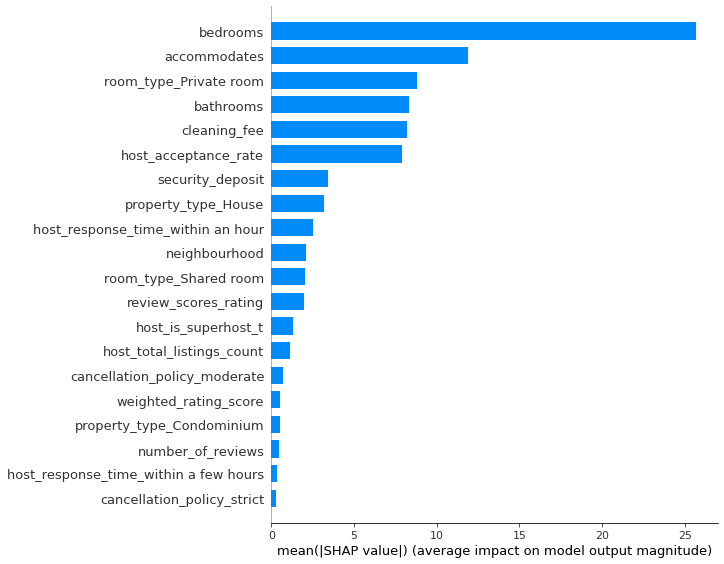

In [63]:
# Creating a summary plot using shap values to get an idea of predictive power of each feature
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

Clearly both review rating and cancellation policy are among the contributors to price (if not at the top) as per the dataset given to us. It is interesting to find how host response time is also influential to price of the listing.